# Desafio 5

## Importación de librerías

In [30]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
from transformers import TFBertModel, BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample
from utils import *

In [31]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"Available GPU(s): {gpus}")
else:
    print("No GPU detected. Using CPU instead.")

Available GPU(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Carga de datos
Utilizaremos como dataset críticas de Google Apps en formato csv.

In [3]:
# URLs for the files
apps_url = 'https://drive.google.com/u/0/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV&export=download&confirm=t'
reviews_url = 'https://drive.google.com/u/0/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv&export=download&confirm=t'

# Filenames for the downloaded files
apps_filename = 'apps.csv'
reviews_filename = 'reviews.csv'

# Download the files
download_file(apps_url, apps_filename)
download_file(reviews_url, reviews_filename)

apps.csv already exists. Skipping download.
reviews.csv already exists. Skipping download.


In [4]:
df = pd.read_csv('reviews.csv')
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [5]:
print("Number of reviews before removing duplicates: ", df.shape[0])

Number of reviews before removing duplicates:  15746


In [6]:
df = df.drop_duplicates(subset='content')
print("Number of reviews after removing duplicates: ", df.shape[0])

Number of reviews after removing duplicates:  10130


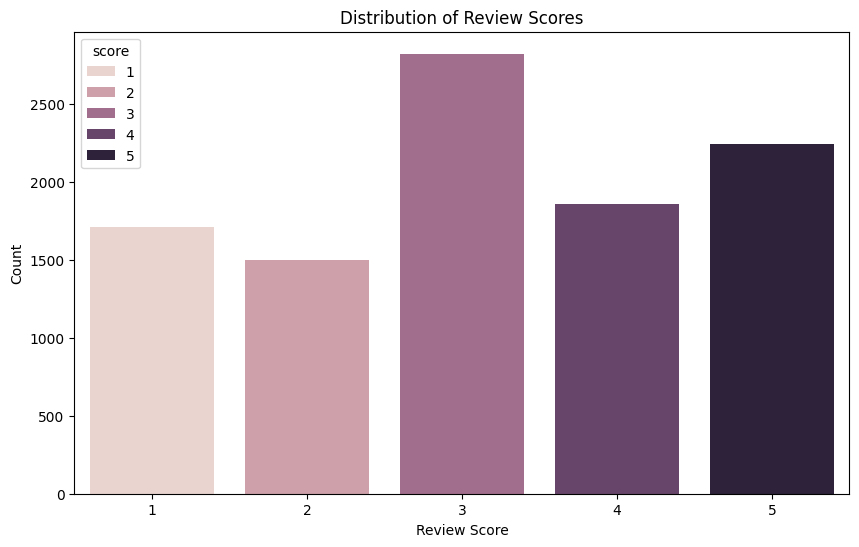

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df.score, hue=df.score)
plt.title('Distribution of Review Scores')
plt.xlabel('Review Score')
plt.ylabel('Count')
plt.show()

## Limpieza y preparación de datos

Existe un desbalanceo en la variable objetivo, habiendo más críticas en la categoría 3 que en las demás. Para balancear el dataset, la mejor alternativa es dividir las categorías en 3 grupos, de manera que cada grupo tenga una cantidad similar de críticas.

In [8]:
df['sentiment'] = df.score.apply(lambda x: 0 if x <=2 else 1 if x == 3 else 2)
class_names = ['negative', 'neutral', 'positive']

In [9]:
print(f'Cantidad de críticas por categoría: {df.sentiment.value_counts()}')

Cantidad de críticas por categoría: sentiment
2    4101
0    3209
1    2820
Name: count, dtype: int64


Reduciendo el dataset a 3 categorías, se obtiene un poco más balanceado.

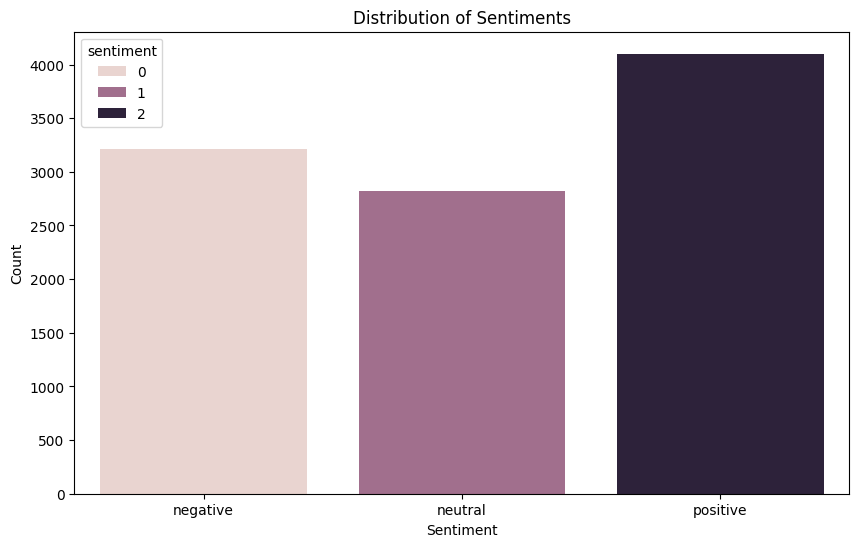

In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df.sentiment, hue=df.sentiment)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=class_names)
plt.show()

Como todavía existe un desbalanceo, se aplicará downsampling a las categorías positivo y negativo para que tengan la misma cantidad de críticas que la categoría neutral. De esa manera, se obtiene un dataset balanceado.

Cantidad de críticas por categoría después del submuestreo: sentiment
2    2820
0    2820
1    2820
Name: count, dtype: int64


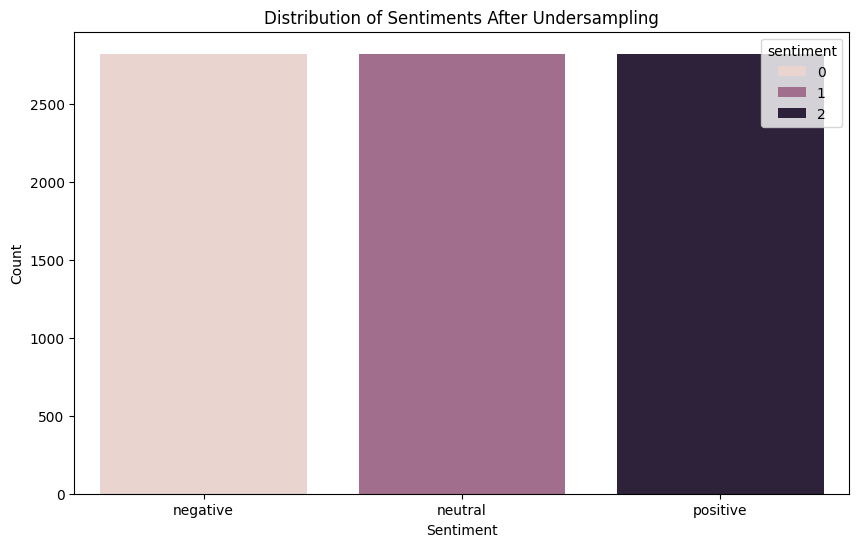

In [36]:
df_positive = df[df.sentiment == 2]
df_negative = df[df.sentiment == 0]
df_neutral = df[df.sentiment == 1]

# Downsampling the majority classes
df_positive_downsampled = resample(
                            df_positive, 
                            replace=False, 
                            n_samples=len(df_neutral),
                            random_state=42
                        )

df_negative_downsampled = resample(
                            df_negative, 
                            replace=False,
                            n_samples=len(df_neutral),
                            random_state=42
                        )

# Concatenating the downsampled majority classes with the minority class
df_balanced = pd.concat([df_positive_downsampled, df_negative_downsampled, df_neutral])
print(f'Cantidad de críticas por categoría después del submuestreo: {df_balanced.sentiment.value_counts()}')

plt.figure(figsize=(10, 6))
sns.countplot(x=df_balanced.sentiment, hue=df_balanced.sentiment)
plt.title('Distribution of Sentiments After Undersampling')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=class_names)
plt.show()

In [37]:
sentences = df_balanced['content'].values
print("Sentences shape:", sentences.shape)

# Display the first three sentences
for i, sentence in enumerate(sentences[:3], 1):
    print(f"Sentence {i}: {sentence}")

Sentences shape: (8460,)
Sentence 1: Good app it helps me be motivated without hesitation nor procastination. Thank you HabitNow!!!! Your love, Aliff
Sentence 2: Easy to use for a big family
Sentence 3: Great for general use and getting better.


A modo de explorar los datos, también se mostrará una gráfica de barras con la longitud de las críticas.

Average sentence length: 182.84905437352245
Max sentence length: 2176
Min sentence length: 1
Median sentence length: 141.0


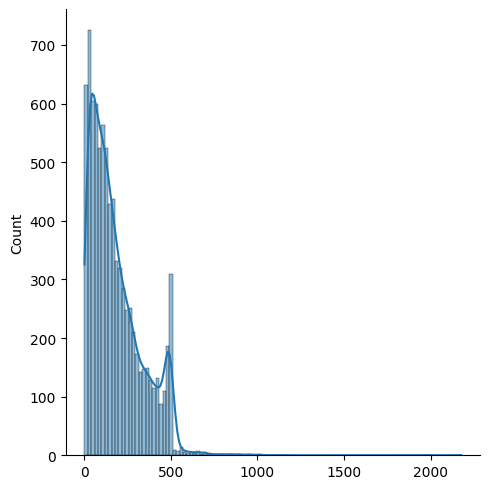

In [38]:
sentence_lens = []

for sentence in sentences:
  sentence_lens.append(len(sentence))

print("Average sentence length:", np.mean(sentence_lens))
print("Max sentence length:", np.max(sentence_lens))
print("Min sentence length:", np.min(sentence_lens))
print("Median sentence length:", np.median(sentence_lens))

sns.displot(sentence_lens, kde=True)

Es necesario convertir la variables objetivo a variables categóricas.

In [40]:
# Extract the 'sentiment' column from the DataFrame
y = df_balanced['sentiment'].values
print(f"y shape: {y.shape}")

# Convert the sentiment labels to one-hot encoded format
y = tf.keras.utils.to_categorical(y, num_classes=3)
print(y[:3])

# Determine the output shape, which is the number of unique sentiment classes
output_shape = y.shape[1]
print("output shape:", output_shape)

y shape: (8460,)
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
output shape: 3


## Definición del dataset

Se utilizará `BertTokenizer` para tokenizar las críticas en la preparación del dataset.

In [41]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Se dividirá el dataset en conjuntos de entrenamiento, validación y test.

In [42]:
indices = np.arange(len(sentences))

idx_train_val, idx_test = train_test_split(indices, test_size=0.2, random_state=42)
idx_train, idx_val = train_test_split(idx_train_val, test_size=0.2, random_state=42)

In [43]:
print(f"Training set size: {idx_train.shape[0]}")
print(f"Validation set size: {idx_val.shape[0]}")
print(f"Test set size: {idx_test.shape[0]}")

Training set size: 5414
Validation set size: 1354
Test set size: 1692


Se convierten los datos a InputExample y posteriormente TensorFlow Datasets.

In [44]:
batch_size = 128
max_length = 120

train_input_examples, validation_input_examples = convert_data_to_examples(sentences, y, idx_train, idx_val)
train_data = convert_examples_to_tf_dataset(list(train_input_examples), bert_tokenizer, output_shape=output_shape, max_length=max_length)

train_data = train_data.shuffle(100).batch(batch_size)

validation_data = convert_examples_to_tf_dataset(list(validation_input_examples), bert_tokenizer, output_shape=output_shape, max_length=max_length)
validation_data = validation_data.batch(batch_size)

Se tokeniza el texto y se convierte a `input_ids` y `attention_mask`.

In [45]:
pred_sentences = [sentences[i] for i in idx_test]
tf_batch = bert_tokenizer(pred_sentences, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

In [46]:
X_test = [
    tf_batch['input_ids'],  
    tf_batch['attention_mask']
]

y_test = y[idx_test]

In [47]:
print(f"X_test[0] shape: {X_test[0].shape}")
print(f"y_test shape: {y_test.shape}")

X_test[0] shape: (1692, 120)
y_test shape: (1692, 3)


## Primer modelo: BERT pre-entrenado con pesos congelados

Se define el modelo BERT pre-entrenado.

In [21]:
bert_model = TFBertModel.from_pretrained("bert-base-uncased")
bert_model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109482240 (417.64 MB)
Trainable params: 109482240 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
def build_model_1(bert_model, max_length, output_shape, freeze_bert=True):
    """
    Build a model using the BERT model as the base
    """   
    # Set BERT model as not trainable
    bert_model.trainable = not freeze_bert

    # Define inputs
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')

    # Pass inputs to BERT model
    outputs = bert_model(input_ids, attention_mask=attention_mask)

    # Extract the pooled output
    pooled_output = outputs.pooler_output

    # Define the rest of the classification layers with batch normalization
    x = tf.keras.layers.Dense(512)(pooled_output)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Dense(256)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    x = tf.keras.layers.Dense(32, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    output = tf.keras.layers.Dense(output_shape, activation='softmax')(x)

    # Create the model
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)
    
    return model

In [23]:
model_1 = build_model_1(bert_model, max_length, output_shape)

# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, weight_decay=0.01)

# Compile the model with F1 score
model_1.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy',tf.keras.metrics.F1Score(average='macro')]
)

# Display model summary
model_1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 120)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 120)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 120, 7                                       

### Entrenamiento

In [81]:
history_1 = model_1.fit(
    train_data, 
    epochs=60, 
    validation_data=validation_data,
)

Epoch 1/60
     51/Unknown - 26s 371ms/step - loss: 2.5158 - accuracy: 0.3145 - f1_score: 0.3067

2024-10-21 00:25:35.195082: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2633983359923849618
2024-10-21 00:25:35.195224: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 5013185750416607992
2024-10-21 00:25:35.195246: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1245853976058810939
2024-10-21 00:25:35.195261: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11447252401941232857
2024-10-21 00:25:35.195265: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 6862658620136205789


51/51 [==============================] - 33s 498ms/step - loss: 2.5158 - accuracy: 0.3145 - f1_score: 0.3067 - val_loss: 2.2823 - val_accuracy: 0.3307 - val_f1_score: 0.2892
Epoch 2/60


2024-10-21 00:25:41.352315: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14379127865737693362
2024-10-21 00:25:41.352364: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-10-21 00:25:41.352370: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 12309001699975271221
2024-10-21 00:25:41.352374: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18093550857373928195
2024-10-21 00:25:41.352376: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2011414110034595221
2024-10-21 00:25:41.352379: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11772750405820974065
2024-10-21 00:25:41.352383: I tensorflow/c

51/51 [==============================] - 23s 457ms/step - loss: 2.4885 - accuracy: 0.3335 - f1_score: 0.3264 - val_loss: 2.2818 - val_accuracy: 0.3467 - val_f1_score: 0.3049
Epoch 3/60
51/51 [==============================] - 23s 454ms/step - loss: 2.4905 - accuracy: 0.3185 - f1_score: 0.3119 - val_loss: 2.2810 - val_accuracy: 0.3677 - val_f1_score: 0.2997
Epoch 4/60
51/51 [==============================] - 23s 455ms/step - loss: 2.4710 - accuracy: 0.3378 - f1_score: 0.3310 - val_loss: 2.2793 - val_accuracy: 0.3652 - val_f1_score: 0.2970
Epoch 5/60
51/51 [==============================] - 23s 457ms/step - loss: 2.4623 - accuracy: 0.3377 - f1_score: 0.3311 - val_loss: 2.2721 - val_accuracy: 0.3899 - val_f1_score: 0.3268
Epoch 6/60
51/51 [==============================] - 23s 455ms/step - loss: 2.4404 - accuracy: 0.3421 - f1_score: 0.3348 - val_loss: 2.2618 - val_accuracy: 0.4004 - val_f1_score: 0.3468
Epoch 7/60
51/51 [==============================] - 23s 458ms/step - loss: 2.4189 - ac

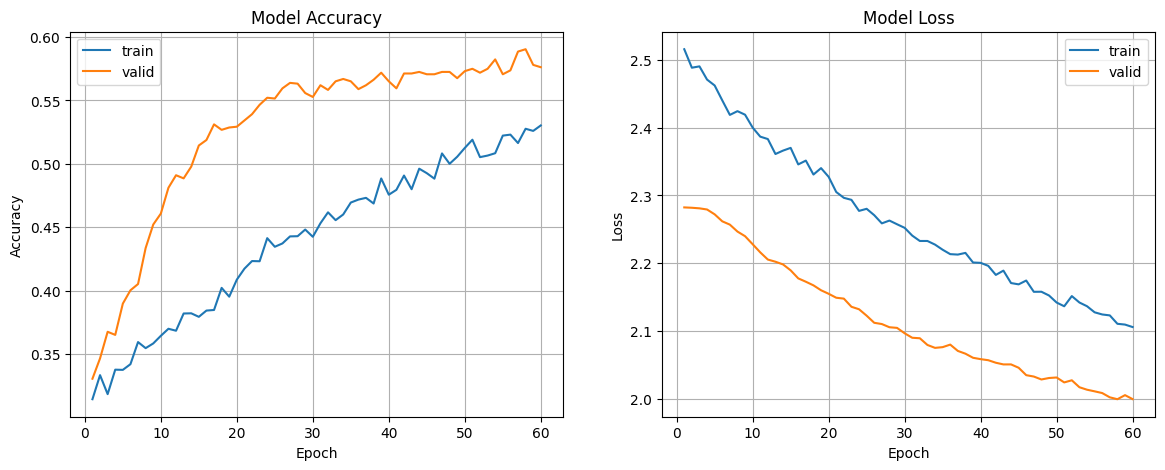

In [82]:
plot_train_metrics(history_1)

Se puede ver que el modelo converge al mismo ritmo en el dataset de validación y de entrenamiento. Sin embargo, el accuracy y la pérdida no llegan a un valor óptimo. Si bien se utilizaron un buen número de épocas, parece que al modelo le falta todavia más entrenamiento. Debido al tiempo que toma entrenar el modelo, de momento se corta el entrenamiento con este resultado.

A continuación se verificará si el desempeño se mantiene con el conjunto de test.

In [92]:
y_hat_prob = model_1.predict(X_test)
y_hat_prob[:3]

64/64 [==============================] - 6s 82ms/step


array([[0.68955404, 0.26790202, 0.042544  ],
       [0.3939277 , 0.2955496 , 0.31052265],
       [0.3600934 , 0.36512998, 0.2747766 ]], dtype=float32)

In [ ]:
y_hat = np.argmax(y_hat_prob, axis=1)

In [93]:
scores = model_1.evaluate(X_test, y_test)

print(f"Test loss: {scores[0]}")
print(f"Test accuracy: {scores[1]}")
print(f"Test F1 Score: {scores[2]}")

64/64 [==============================] - 7s 84ms/step - loss: 1.9815 - accuracy: 0.6037 - f1_score: 0.5295
Test loss: 1.9814893007278442
Test accuracy: 0.6036525368690491
Test F1 Score: 0.5294635891914368


Las métricas obtenidas para el conjunto de test son consistentes con las obtenidas en el conjunto de validación.

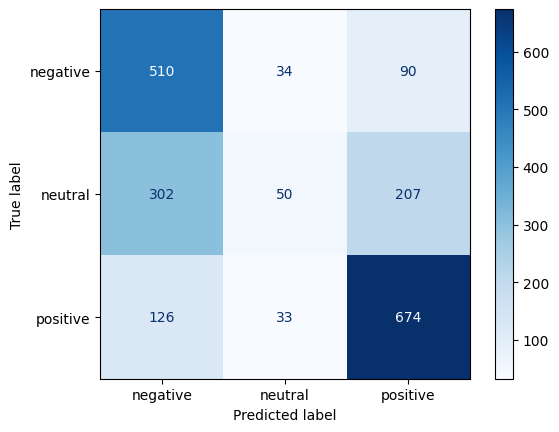

In [94]:
cm = confusion_matrix(y_test.argmax(axis=1), y_hat)
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cmd.plot(cmap=plt.cm.Blues)
plt.show()

La matriz de confusión muestra que el modelo clasifica correctamente una cantidad significativa de instancias negativas y positivas, pero tiene dificultades con la clase neutral, ya que una gran parte de estas se clasifican incorrectamente como negativas o positivas.

In [95]:
model_1.save_weights('bert_model_1_weights.h5')

In [96]:
# Load the bert model
bert_model = TFBertModel.from_pretrained("bert-base-uncased")
# Build the model
model_1_loaded = build_model_1(bert_model, max_length, output_shape)
# Load the weights
model_1_loaded.load_weights('bert_model_1_weights.h5')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [97]:
text = "I love this app!"

# Tokenize the text
tf_batch = bert_tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_length, 
    return_token_type_ids=False,
    return_attention_mask=True,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

print("Inputs ids:", tf_batch['input_ids'])
print("Attention mask:", tf_batch['attention_mask'])

X_test = [
    tf_batch['input_ids'],  
    tf_batch['attention_mask']
]

Inputs ids: tf.Tensor(
[[  101  1045  2293  2023 10439   999   102     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]], shape=(1, 140), dtype=int32)
Attention mask: tf.Tensor(
[[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [98]:
y_prob_ensayo = model_1_loaded.predict(X_ensayo)
y_prob = np.argmax(y_prob_ensayo, axis=1)
print("Clasificación:", class_names[int(y_prob)])

1/1 [==============================] - 2s 2s/step
Clasificación: positive


In [99]:
text = "I hate this product, it is terrible!"

# Tokenize the text
tf_batch = bert_tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_length, 
    return_token_type_ids=False,
    return_attention_mask=True,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

X_test = [
    tf_batch['input_ids'],  
    tf_batch['attention_mask']
]

y_prob_test = model_1_loaded.predict(X_test)
y_prob = np.argmax(y_prob_test, axis=1)
print("Clasificación:", class_names[int(y_prob)])

1/1 [==============================] - 0s 84ms/step
Clasificación: negative


In [103]:
text = "The app is okay, nothing special."

# Tokenize the text
tf_batch = bert_tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_length, 
    return_token_type_ids=False,
    return_attention_mask=True,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

X_test = [
    tf_batch['input_ids'],  
    tf_batch['attention_mask']
]

y_prob_test = model_1_loaded.predict(X_test)
y_prob = np.argmax(y_prob_test, axis=1)
print("Clasificación:", class_names[int(y_prob)])

1/1 [==============================] - 0s 116ms/step
Clasificación: positive


Como se puede ver en las pruebas realizadas, el modelo con los pesos cargados realiza clasificaciones correctas.

## Segundo modelo: BERT Fine tuning

Para evitar problemas con la memoria de la GPU, se utilizará un tamaño de batch más pequeño para el fine tuning.

In [48]:
batch_size = 32
max_length = 140

train_input_examples, validation_input_examples = convert_data_to_examples(sentences, y, idx_train, idx_val)
train_data = convert_examples_to_tf_dataset(list(train_input_examples), bert_tokenizer, output_shape=output_shape, max_length=max_length)

train_data = train_data.shuffle(100).batch(batch_size)

validation_data = convert_examples_to_tf_dataset(list(validation_input_examples), bert_tokenizer, output_shape=output_shape, max_length=max_length)
validation_data = validation_data.batch(batch_size)

El resto del procesamiento es similar al anterior.

In [49]:
pred_sentences = [sentences[i] for i in idx_test]
tf_batch = bert_tokenizer(pred_sentences, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

In [50]:
X_test = [
    tf_batch['input_ids'],  
    tf_batch['attention_mask']
]

y_test = y[idx_test]

In [51]:
print(f"X_test[0] shape: {X_test[0].shape}")
print(f"y_test shape: {y_test.shape}")

X_test[0] shape: (1692, 140)
y_test shape: (1692, 3)


Definiendo el modelo BERT pre-entrenado con pesos no congelados para realizar fine tuning. 

In [52]:
def build_model_2(bert_model, max_length, output_shape, freeze_bert=False):
    """
    Build a model using the BERT model as the base
    """   
    # Set BERT model trainable or not
    bert_model.trainable = not freeze_bert

    # Define inputs
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')

    # Pass inputs to BERT model
    outputs = bert_model(input_ids, attention_mask=attention_mask)

    # Extract the pooled output
    pooled_output = outputs.pooler_output

    # Define the rest of the classification layers with batch normalization
    x = tf.keras.layers.Dropout(0.35)(pooled_output)
    x = tf.keras.layers.Dense(32)(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    output = tf.keras.layers.Dense(output_shape, activation='softmax')(x)

    # Create the model
    model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=output)
    
    return model

In [53]:
# Load the pre-trained BERT model
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

# Build the model without freezing the BERT model
model_2 = build_model_2(bert_model, max_length, output_shape, freeze_bert=False)

for layer in model_2.layers:
  layer.trainable = True

# Define the optimizer with weight decay 
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, weight_decay=0.01)

# Compile the model
model_2.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'] 
)

model_2.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 140)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 140)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 140, 7                                     

In [54]:
history_2 = model_2.fit(
    train_data, 
    epochs=8,
    validation_data=validation_data,
)

Epoch 1/8
    170/Unknown - 58s 229ms/step - loss: 0.9252 - accuracy: 0.5353

2024-10-21 02:06:01.275765: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 95183044109951994
2024-10-21 02:06:01.275800: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14870479012751365542
2024-10-21 02:06:01.275803: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 2152260465830076400
2024-10-21 02:06:01.275805: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 15047347346417695615


170/170 [==============================] - 64s 263ms/step - loss: 0.9252 - accuracy: 0.5353 - val_loss: 0.7500 - val_accuracy: 0.6403
Epoch 2/8


2024-10-21 02:06:06.815021: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 12065781537649750840
2024-10-21 02:06:06.815076: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 5103982760172801174
2024-10-21 02:06:06.815080: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-10-21 02:06:06.815107: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7188212429236667619
2024-10-21 02:06:06.815112: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 7617176323217180288


170/170 [==============================] - 42s 250ms/step - loss: 0.7588 - accuracy: 0.6415 - val_loss: 0.7478 - val_accuracy: 0.6581
Epoch 3/8
170/170 [==============================] - 43s 250ms/step - loss: 0.6715 - accuracy: 0.6919 - val_loss: 0.7714 - val_accuracy: 0.6499
Epoch 4/8
170/170 [==============================] - 43s 251ms/step - loss: 0.5931 - accuracy: 0.7351 - val_loss: 0.8555 - val_accuracy: 0.6551
Epoch 5/8
170/170 [==============================] - 43s 252ms/step - loss: 0.5114 - accuracy: 0.7824 - val_loss: 0.8594 - val_accuracy: 0.6617
Epoch 6/8
170/170 [==============================] - 43s 251ms/step - loss: 0.4325 - accuracy: 0.8277 - val_loss: 0.9424 - val_accuracy: 0.6492
Epoch 7/8
170/170 [==============================] - 42s 248ms/step - loss: 0.3604 - accuracy: 0.8633 - val_loss: 1.0837 - val_accuracy: 0.6588
Epoch 8/8
170/170 [==============================] - 42s 249ms/step - loss: 0.2927 - accuracy: 0.8975 - val_loss: 1.1622 - val_accuracy: 0.6521


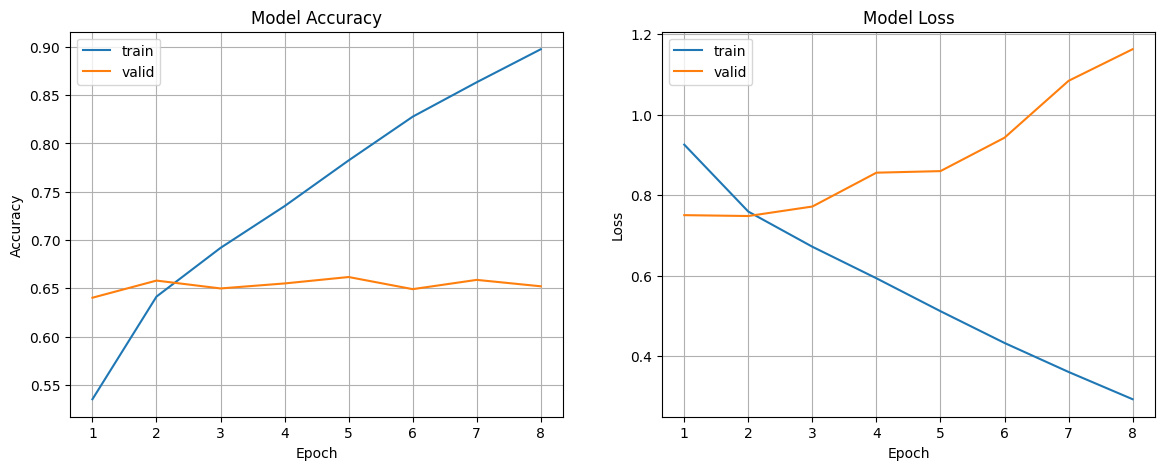

In [55]:
plot_train_metrics(history_2)

A continuación se verificará si el desempeño se mantiene con el conjunto de test.

In [56]:
y_hat_prob = model_2.predict(X_test)
y_hat_prob[:3]

53/53 [==============================] - 6s 82ms/step


array([[7.5662953e-01, 2.1141809e-01, 3.1952396e-02],
       [1.4735452e-02, 9.3510050e-01, 5.0164033e-02],
       [9.3962801e-05, 6.6276487e-05, 9.9983978e-01]], dtype=float32)

In [57]:
y_hat = np.argmax(y_hat_prob, axis=1)

In [58]:
scores = model_2.evaluate(X_test, y_test)

print(f"Test loss: {scores[0]}")
print(f"Test accuracy: {scores[1]}")

53/53 [==============================] - 6s 83ms/step - loss: 1.1230 - accuracy: 0.6625
Test loss: 1.1230450868606567
Test accuracy: 0.6625295281410217


Las métricas obtenidas para el conjunto de test son consistentes con las obtenidas en el conjunto de validación.

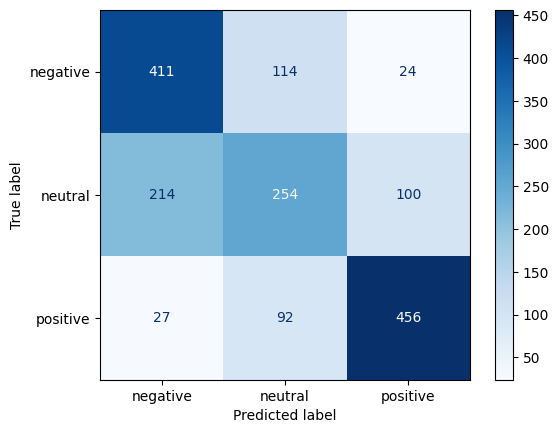

In [59]:
cm = confusion_matrix(y_test.argmax(axis=1), y_hat)
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cmd.plot(cmap=plt.cm.Blues)
plt.show()

La matriz de confusión muestra que el modelo ha mejorado en la clasificación de la clase neutral, pero ha empeorado en la clasificación de las clases negativas y positivas.

In [61]:
model_2.save_weights('bert_model_2_weights.h5')

In [62]:
# Load the bert model
bert_model = TFBertModel.from_pretrained("bert-base-uncased")
# Build the model
model_2_loaded = build_model_2(bert_model, max_length, output_shape, freeze_bert=False)
# Load the weights
model_2_loaded.load_weights('bert_model_2_weights.h5')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [63]:
text = "I love this app!"

# Tokenize the text
tf_batch = bert_tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_length, 
    return_token_type_ids=False,
    return_attention_mask=True,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

print("Inputs ids:", tf_batch['input_ids'])
print("Attention mask:", tf_batch['attention_mask'])

X_test = [
    tf_batch['input_ids'],  
    tf_batch['attention_mask']
]

Inputs ids: tf.Tensor(
[[  101  1045  2293  2023 10439   999   102     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]], shape=(1, 140), dtype=int32)
Attention mask: tf.Tensor(
[[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [65]:
y_prob_ensayo = model_2_loaded.predict(X_test)
y_prob = np.argmax(y_prob_ensayo, axis=1)
print("Clasificación:", class_names[int(y_prob)])

1/1 [==============================] - 2s 2s/step
Clasificación: positive


In [66]:
text = "I hate this product, it is terrible!"

# Tokenize the text
tf_batch = bert_tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_length, 
    return_token_type_ids=False,
    return_attention_mask=True,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

X_test = [
    tf_batch['input_ids'],  
    tf_batch['attention_mask']
]

y_prob_test = model_2_loaded.predict(X_test)
y_prob = np.argmax(y_prob_test, axis=1)
print("Clasificación:", class_names[int(y_prob)])

1/1 [==============================] - 0s 109ms/step
Clasificación: negative


In [67]:
text = "The app is okay, nothing special."

# Tokenize the text
tf_batch = bert_tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_length, 
    return_token_type_ids=False,
    return_attention_mask=True,
    padding='max_length',
    truncation=True,
    return_tensors='tf'
)

X_test = [
    tf_batch['input_ids'],  
    tf_batch['attention_mask']
]

y_prob_test = model_2_loaded.predict(X_test)
y_prob = np.argmax(y_prob_test, axis=1)
print("Clasificación:", class_names[int(y_prob)])

1/1 [==============================] - 0s 105ms/step
Clasificación: negative
